In [1]:
import warnings
import pickle
import sys
import pandas as pd
import time
warnings.filterwarnings('ignore')

# add paths for modules
sys.path.append('../visualization')
sys.path.append('../features')
sys.path.append('../datawrangling')

# import modules
import visualize
import geometry_utils
import dataloader_paths, dataloader_geo

from maritime_traffic_network import MaritimeTrafficNetwork
from dijkstra_path_prediction import DijkstraPathPrediction
import prediction_model_evaluation_metrics as metrics

In [2]:
# model parameters
datasize = 'full'
location = 'oslo'
model_date = '202208'
DP_tol = 10
min_samples = 20

# train/test data parameters
train_dates = ['202206', '202207', '202208']
test_dates = ['202209']
train_filter = None        #None, 'Last', 'Passasjer', 'Tank',  'Fisk', 'Unknown', 'Auxiliary'
test_filter = None

# load model
network_name = model_date+'_waypoints_DP'+str(DP_tol)+'_HDBSCAN'+str(min_samples)+'_'+location+'_'+datasize+'_UTM'
network_path = '../../models/networks/best_networks/' + network_name + '.obj'
fileObj = open(network_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': '../../data/processed/202208_points_oslo_cleaned_meta_full_dualSplit_2.parquet',
 'DP_tolerance': 10,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 20,
 'clustering_min_cluster_size': 20,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.01, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]),
 'graph_generation_max_distance': 20,
 'graph_generation_max_angle': 45}

In [3]:
network.prune_graph(1)

Pruning...
------------------------
Pruned Graph:
Number of nodes: 816 (4 isolated)
Number of edges: 3860
------------------------


In [4]:
# Load training data from file
path_prefix = '../../data/paths/'
training_paths = dataloader_paths.load_path_training_data(path_prefix, network_name, train_dates, filter=train_filter, data_version='')

In [5]:
# train model
model = DijkstraPathPrediction()
model.train(network.G_pruned, training_paths)

In [6]:
# Load test data from file
selection_start = 0
selection_end = -1
selection_step = 80
traj_path_prefix = '../../data/processed/'
test_paths = dataloader_paths.load_path_test_data(path_prefix, network_name, test_dates, 
                                                  selection_start, selection_end, selection_step, filter=test_filter, data_version='')
test_trajectories = dataloader_geo.load_trajectories(traj_path_prefix, location, network.crs, test_dates)
print('# of training paths:', len(training_paths))
print('# of test paths:', len(test_paths))

# of training paths: 21058
# of test paths: 80


In [7]:
# predict
n_start_nodes = 1

start_time = time.time()

predictions = model.predict(test_paths, n_start_nodes=n_start_nodes, weight='inverse_density')  # 'inverse_density', 'inverse_passages', 'length'

end_time = time.time()  # end timer
print(f'Time elapsed: {(end_time-start_time)/60:.2f} minutes')
pps = len(test_paths)/(end_time-start_time)
print('Predictions per second: ', pps)


Making predictions for 80 samples
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...Done!
Time elapsed: 0.00 minutes
Predictions per second:  2415.6910627636753


Evaluating 80 samples for path prediction task
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...Done!


Time elapsed: 0.05 minutes


Percentage of unsuccessful predictions: 0.00%
Mean SSPD: 66.22m
Median SSPD: 30.37m
Mean choice_accuracy: 0.4495


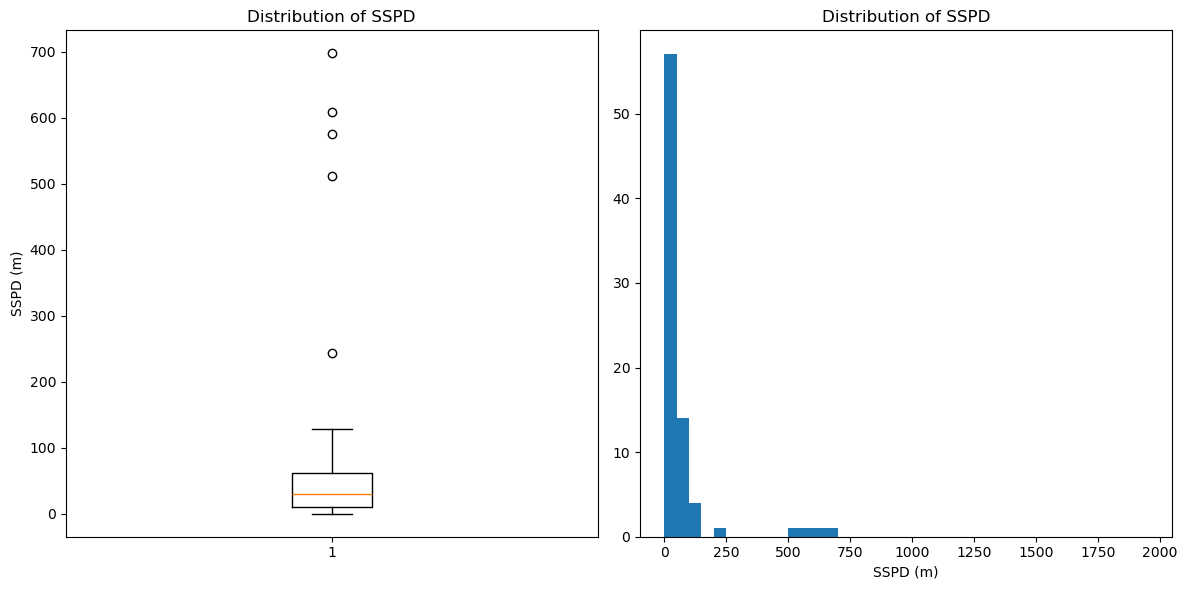

In [8]:
# evaluate
eval_mode = 'path'
evaluation_results, fig = metrics.evaluate_given_predictions('path', predictions, test_trajectories, 
                                                             network, n_start_nodes=n_start_nodes, eval_mode=eval_mode)

In [9]:
# Make predictions with the Dijkstra model and plot
i = 2
example = test_paths.iloc[i]
mmsi = example.mmsi
start_node = [example.path[0]]
end_node = example.path[-1]
true_path = example.path
trajectory = test_trajectories.get_trajectory(mmsi)

predictions, flag = model.predict_path(start_node[-1], end_node)
predictions = start_node[:-1] + predictions
predictions = {tuple(predictions):1}

map = visualize.map_prediction_and_ground_truth(predictions, start_node, trajectory, true_path, network, 
                                                min_passages=2, opacity=0.2, location=location, end_node=end_node)
map.save('../../reports/maps/'+network_name+'_dijkstra_predictions.html')
print(f'Map saved under {"../../reports/maps/"+network_name+"_dijkstra_predictions.html"}')

Map saved under ../../reports/maps/202208_waypoints_DP10_HDBSCAN20_oslo_full_UTM_dijkstra_predictions.html


In [10]:
from make_trajectories_from_AIS import add_ship_metadata
import matplotlib.pyplot as plt

# add original mmsi column back to dataframe
evaluation_results.rename(columns={'mmsi':'id'}, inplace=True)
evaluation_results['mmsi'] = evaluation_results['id'].str[:9].astype(int)

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


Ship metadata has   4142 unique MMSIs
AIS raw data has    29 unique MMSIs
Overlap:            23 MMSIs


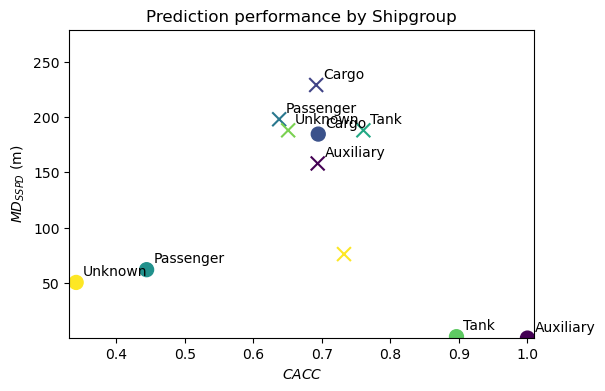

In [11]:
# add metadata to each mmsi
meta_file = '../../data/external/seilas-2022.csv'
evaluation_results_meta = add_ship_metadata(meta_file, evaluation_results)

# get choice accuracy and SSPD by shipgroup
sspd_by_group = evaluation_results_meta.groupby(['skipsgruppe'])['SSPD'].mean()
cacc_by_group = evaluation_results_meta.groupby(['skipsgruppe'])['choice_accuracy'].mean()

x = cacc_by_group.values
y = sspd_by_group.values
categories = sspd_by_group.index

data = {
    'skipsgruppe': ['Auxiliary', 'Cargo', 'Fishing', 'Passenger', 'Tank', 'Unknown'],
    'value': [0.6939, 0.6917, 0.6377, 0.7606, 0.6508, 0.7323]
}
cacc_new = pd.DataFrame(data)
data = {
    'skipsgruppe': ['Auxiliary', 'Cargo', 'Fishing', 'Passenger', 'Tank', 'Unknown'],
    'value': [158, 229, 198, 188, 188, 76]
}
sspd_new = pd.DataFrame(data)
x_new = cacc_new['value']
y_new = sspd_new['value']
categories_new = cacc_new['skipsgruppe']

fig, ax = plt.subplots(figsize=[6, 4])

# Scatter plot with different colors and markers for each category
scatter = ax.scatter(x, y, c=range(len(categories)), cmap='viridis', marker='o', s=100)
scatter = ax.scatter(x_new, y_new, c=range(len(categories_new)), cmap='viridis', marker='x', s=100)

# Annotate each point with the ship category name
for i, category in enumerate(categories):
    ax.annotate(category, (x[i], y[i]), textcoords="offset points", xytext=(5,5), ha='left')
    ax.annotate(category, (x_new[i], y_new[i]), textcoords="offset points", xytext=(5,5), ha='left')

max_x_value = max(max(x), max(x_new))
max_y_value = max(max(y), max(y_new))
min_x_value = min(min(x), min(x_new))
min_y_value = min(min(x), min(x_new))
ax.set_xlim(min_x_value-0.01, max_x_value+0.01)
ax.set_ylim(min_y_value, max_y_value+50)

ax.set_xlabel('$CACC$')
ax.set_ylabel('$MD_{SSPD}$ (m)')
plt.title('Prediction performance by Shipgroup')
plt.savefig('prediction_performance_by_ship_category_tromso_Dijkstra.pdf')

plt.show()

In [12]:
cacc_by_group

skipsgruppe
Auxiliary    1.000000
Cargo        0.694724
Passenger    0.444274
Tank         0.896429
Unknown      0.341458
Name: choice_accuracy, dtype: float64

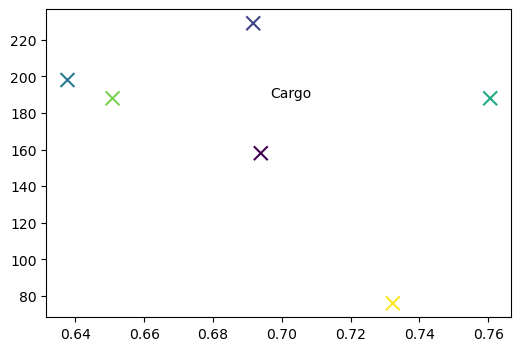

In [13]:
x_new = cacc_new['value']
y_new = sspd_new['value']
categories_new = cacc_new['skipsgruppe']
fig, ax = plt.subplots(figsize=[6, 4])

# Scatter plot with different colors and markers for each category
scatter = ax.scatter(x_new, y_new, c=range(len(categories_new)), cmap='viridis', marker='x', s=100)

# Annotate each point with the ship category name
for i, category in enumerate(categories):
    ax.annotate(category, (x[i], y[i]), textcoords="offset points", xytext=(5,5), ha='left')